## Batch correction prior to running cNMF

The batch effect correction illustrated here is to use [Harmony](#https://github.com/immunogenomics/harmony) but adapted to correct the counts rather than just the PCs. Then you pass the correct counts and the uncorrect TP10K matrix to cNMF and it learns the GEP usages using the corrected data and then re-fits the program spectras using the uncorrected TP10K matrix


In [29]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
from cnmf import cNMF, Preprocess
import seaborn as sns
import anndata as ad
    
np.random.seed(14)

In [9]:
adata = sc.read('data/raw_data/human_data/seurat_filtered_harmony_08_28_23.h5ad')

# First run cNMF without batch correction to illustrate the batch effect in the dataset
* create cNMF instance and prepare analyses (creates tmp files)

In [19]:
cnmf_obj = cNMF(output_dir='data/cnmf', name='NoBatchCorrection')
cnmf_obj.prepare(counts_fn='data/raw_data/human_data/seurat_filtered_harmony_08_28_23_counts.txt', components=[12], n_iter=100, seed=14)

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/cnmf/cnmf.py:327: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  var=pd.DataFrame(index=input_counts.columns))
/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


* run factorize on command line to parallelise

In [48]:
cmd = " &\n".join([f"cnmf factorize --output-dir data/cnmf \
                                   --name NoBatchCorrection \
                                   --worker-index {w} \
                                   --total-workers 8" for w in range(0,8)])
print(cmd)
!{cmd}

cnmf factorize --output-dir data/cnmf                                    --name NoBatchCorrection                                    --worker-index 0                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name NoBatchCorrection                                    --worker-index 1                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name NoBatchCorrection                                    --worker-index 2                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name NoBatchCorrection                                    --worker-index 3                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name NoBatchCorrection                                    --worker-index 4                               

Combining factorizations for k=12.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_73.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_78.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_81.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_86.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_89.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_90.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_94.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_97.df.npz. Skipping.
Missing file: data/cnmf/NoBatchCorrection/cnmf_tmp/NoBatchCorrection.spectra.k_12.iter_98.df.npz. Ski

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


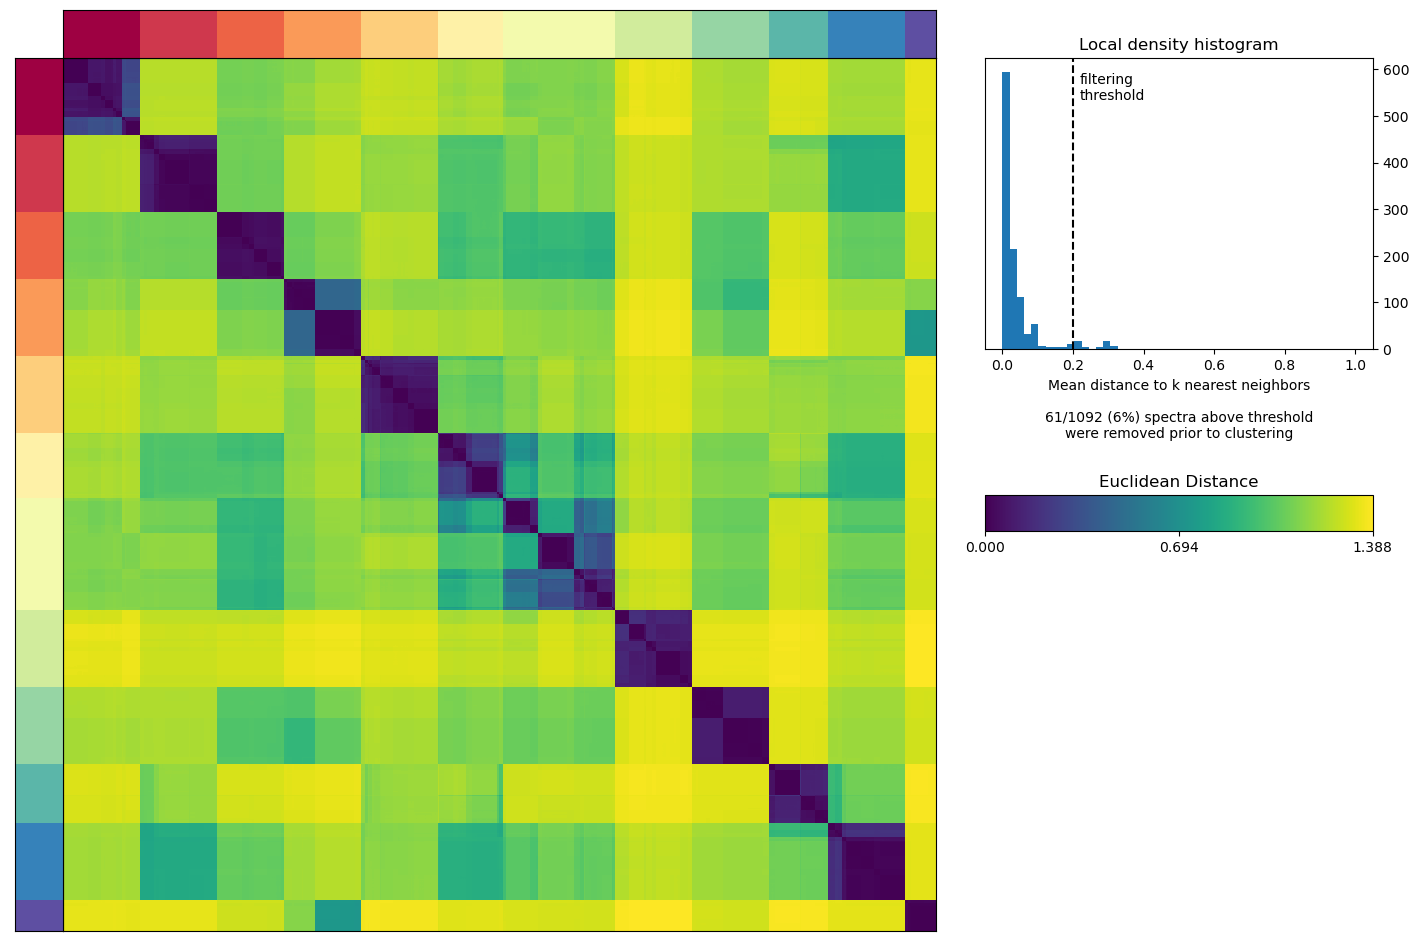

In [55]:
cnmf_obj.combine(skip_missing_files=True)
cnmf_obj.consensus(k=12, density_threshold=0.2, show_clustering=True, close_clustergram_fig=False)

In [57]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=12, density_threshold=0.2)
usage.head()

,1,2,3,4,5,6,7,8,9,10,11,12
CD4_1_Thymus_878524,0.000000,0.007367,0.017285,0.096579,0.010381,0.000000,0.172308,0.010994,0.030371,0.000000,0.543577,0.111140
CD4_1_Thymus_679405,0.018821,0.014008,0.000000,0.013778,0.000000,0.000000,0.054713,0.000000,0.000000,0.000000,0.663279,0.235401
CD4_1_Thymus_281188,0.000000,0.000000,0.000000,0.114543,0.000000,0.089077,0.247107,0.000000,0.026383,0.000000,0.522889,0.000000
CD4_1_Thymus_285601,0.644080,0.071928,0.000000,0.108653,0.008875,0.000000,0.000000,0.004659,0.147017,0.013223,0.000000,0.001566
CD4_1_Thymus_174537,0.000000,0.017900,0.000000,0.133005,0.000000,0.017451,0.173806,0.012291,0.030284,0.009206,0.449297,0.156759


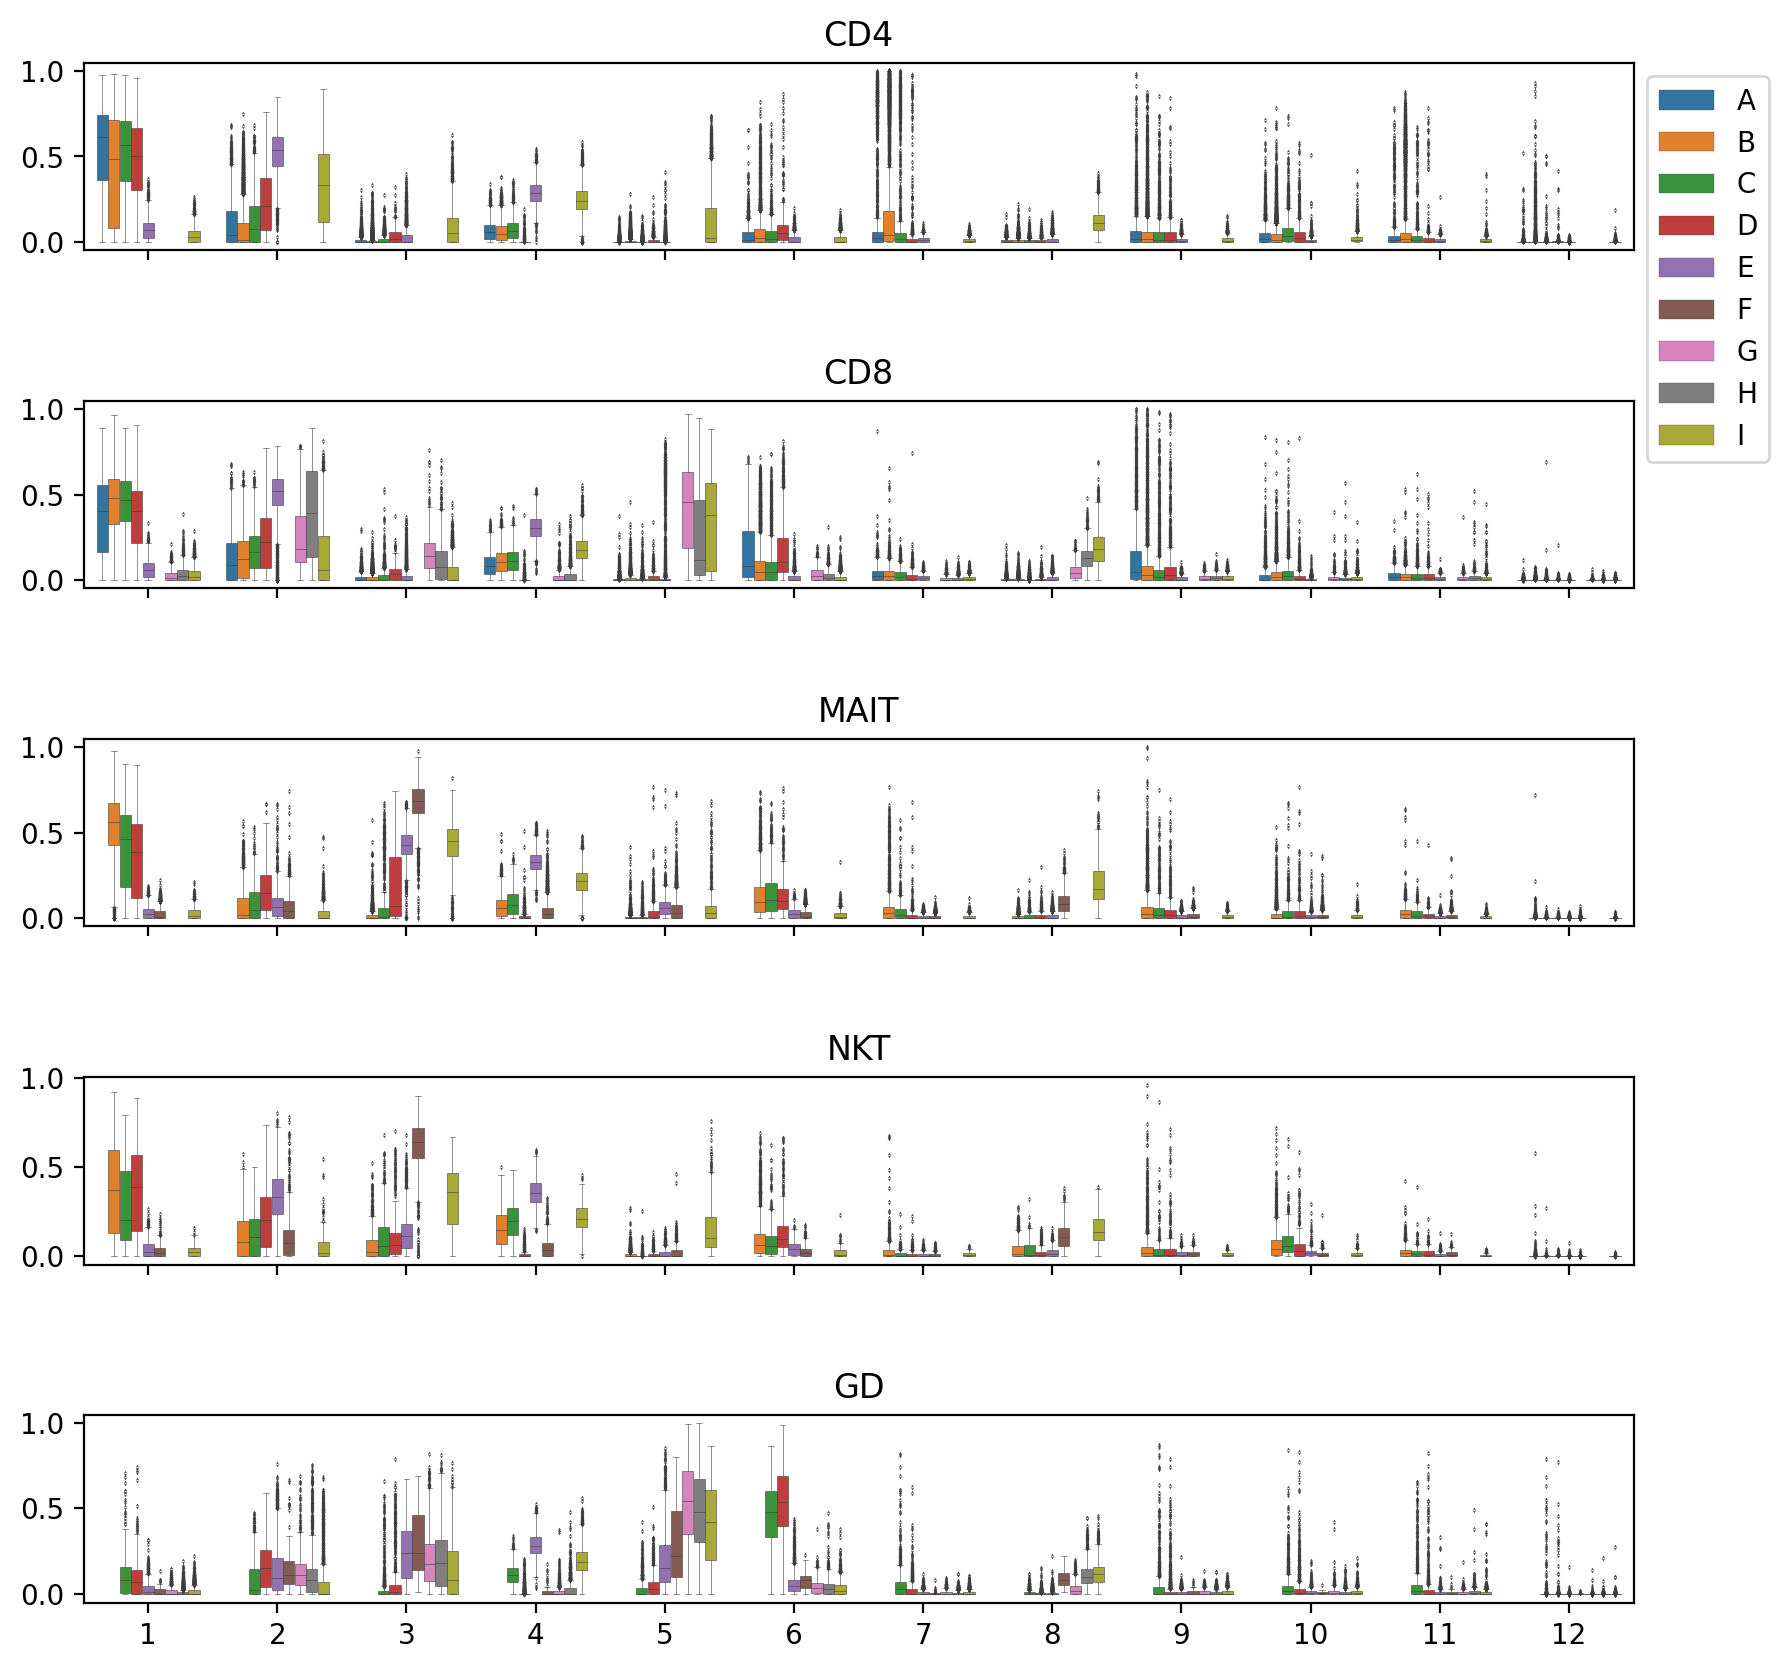

In [88]:
usage_norm_forplot = usage.unstack().reset_index()
usage_norm_forplot = pd.merge(left=usage_norm_forplot, right=adata.obs[['cell.ident', 'Batch']], left_on='level_1', right_index=True)
usage_norm_forplot.columns = ['GEP', 'cell', 'usage', 'cell.ident', 'batch']

cluster_order =["CD4", "CD8",  "MAIT", "NKT",  "GD"]
(fig,axes) = plt.subplots(len(cluster_order),1, figsize=(10,10), dpi=200, gridspec_kw={'hspace':.8})
for i,k in enumerate(cluster_order):
    g = usage_norm_forplot.loc[usage_norm_forplot['cell.ident'] == k, :]
    sns.boxplot(x='GEP', y='usage', hue='batch', ax=axes[i], data=g,
                fliersize=0.05,
                linewidth=0.2
               )
    axes[i].set_title(k)
    axes[i].legend(bbox_to_anchor=(1,1))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if i != (len(cluster_order)-1):
        axes[i].set_xticklabels([])
        
    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(bbox_to_anchor=(1,1))
#plt.savefig()

# Batch effect correction

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


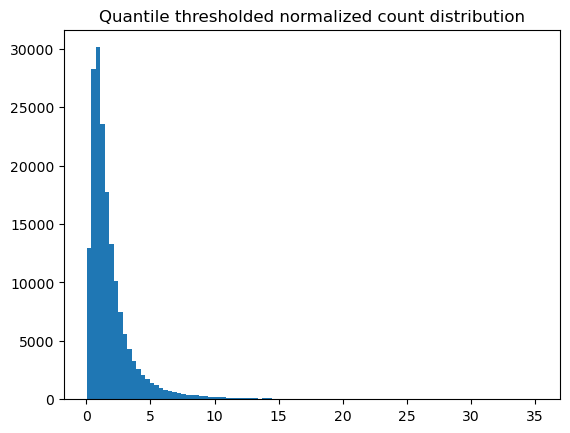

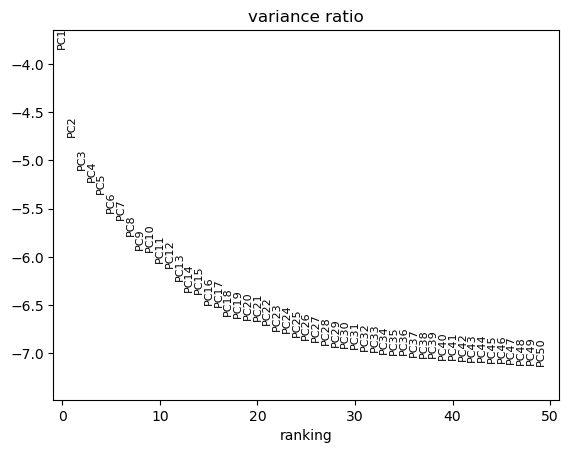

2023-08-31 14:12:48,739 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-31 14:13:01,493 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-31 14:13:01,726 - harmonypy - INFO - Iteration 1 of 20
2023-08-31 14:13:23,463 - harmonypy - INFO - Iteration 2 of 20
2023-08-31 14:13:46,520 - harmonypy - INFO - Converged after 2 iterations


Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


In [71]:
p = Preprocess(random_seed=14)
(adata_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata, harmony_vars=["Batch", "Method"], n_top_rna_genes = 2000,
                                                     max_scaled_thresh = None, quantile_thresh = .9999, makeplots=True,
                                                    save_output_base='data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts')

* The corrected data contains only the high-variance genes whereas the TP10K data contains all genes
* the hvgs output is just a list of the highvariance genes
* files saved to 

    - data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.Corrected.HVG.Varnorm.h5ad
    - data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.TP10K.h5ad
    - data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.Corrected.HVGs.txt

In [72]:
adata_c

AnnData object with n_obs × n_vars = 78355 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell.ident', 'Sex', 'Age_in_weeks', 'Donor', 'Batch', 'Method', 'Tissue', 'group.ident', 'RNA_snn_res.0.7', 'seurat_clusters', 'Test_cell_ident_for_cLISI', 'RNA_snn_res.1.2', 'new_clusters', 'Egress_score1', 'TCRa_g_chain', 'TCRa_g_clonotype', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCRb_d_chain', 'TCRb_d_clonotype', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_CDR3_Translation_Dominant', 'TRAV10_TRAJ18', 'TRAV1_TRAJ33', 'TRAV1', 'Effectorness1', 'Naiveness1', 'Type_3_score1', 'new_clusters_id', 'cell_id', 'GEP_Scores_2', 'GEP_Scores_5', 'GEP_Scores_3', 'GEP_Scores_1', 'GEP_Scores_4', 'GEP_Scores_12', 'GEP_Scores_6', 'GEP_Scores_7', 'GEP_Scores_8', 'GEP_Scores_10', 'GEP_Scores_9', 'GEP_Scores_11'
    var: 'features_renamed'

In [73]:
hvgs[:5]

['ABCA1', 'ABCA9', 'ABCC2', 'ABHD12B', 'ABHD15.AS1']

In [74]:
adata_tp10k

AnnData object with n_obs × n_vars = 78355 × 17204
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell.ident', 'Sex', 'Age_in_weeks', 'Donor', 'Batch', 'Method', 'Tissue', 'group.ident', 'RNA_snn_res.0.7', 'seurat_clusters', 'Test_cell_ident_for_cLISI', 'RNA_snn_res.1.2', 'new_clusters', 'Egress_score1', 'TCRa_g_chain', 'TCRa_g_clonotype', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCRb_d_chain', 'TCRb_d_clonotype', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_CDR3_Translation_Dominant', 'TRAV10_TRAJ18', 'TRAV1_TRAJ33', 'TRAV1', 'Effectorness1', 'Naiveness1', 'Type_3_score1', 'new_clusters_id', 'cell_id', 'GEP_Scores_2', 'GEP_Scores_5', 'GEP_Scores_3', 'GEP_Scores_1', 'GEP_Scores_4', 'GEP_Scores_12', 'GEP_Scores_6', 'GEP_Scores_7', 'GEP_Scores_8', 'GEP_Scores_10', 'GEP_Scores_9', 'GEP_Scores_11', 'n_counts'
    var: 'feat

* use corrected output files as the inputs for the cNMF prepare step

In [76]:
cnmf_obj_corrected = cNMF(output_dir='data/cnmf', name='BatchCorrection')
cnmf_obj_corrected.prepare(counts_fn='data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.Corrected.HVG.Varnorm.h5ad',
                           tpm_fn='data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.TP10K.h5ad',
                           genes_file='data/cnmf/BatchCorrection/seurat_filtered_harmony_08_28_23_counts.Corrected.HVGs.txt',
                           components=[12], n_iter=100, seed=14, num_highvar_genes=2000)

Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


In [77]:
cmd = " &\n".join([f"cnmf factorize --output-dir data/cnmf \
                                   --name BatchCorrection \
                                   --worker-index {w} \
                                   --total-workers 8" for w in range(0,8)])
print(cmd)
!{cmd}

cnmf factorize --output-dir data/cnmf                                    --name BatchCorrection                                    --worker-index 0                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name BatchCorrection                                    --worker-index 1                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name BatchCorrection                                    --worker-index 2                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name BatchCorrection                                    --worker-index 3                                    --total-workers 8 &
cnmf factorize --output-dir data/cnmf                                    --name BatchCorrection                                    --worker-index 4                                    --tot

Combining factorizations for k=12.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_50.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_56.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_58.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_60.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_64.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_65.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_66.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_68.df.npz. Skipping.
Missing file: data/cnmf/BatchCorrection/cnmf_tmp/BatchCorrection.spectra.k_12.iter_70.df.npz. Skipping.
Missing file: data/cnmf/Batch

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


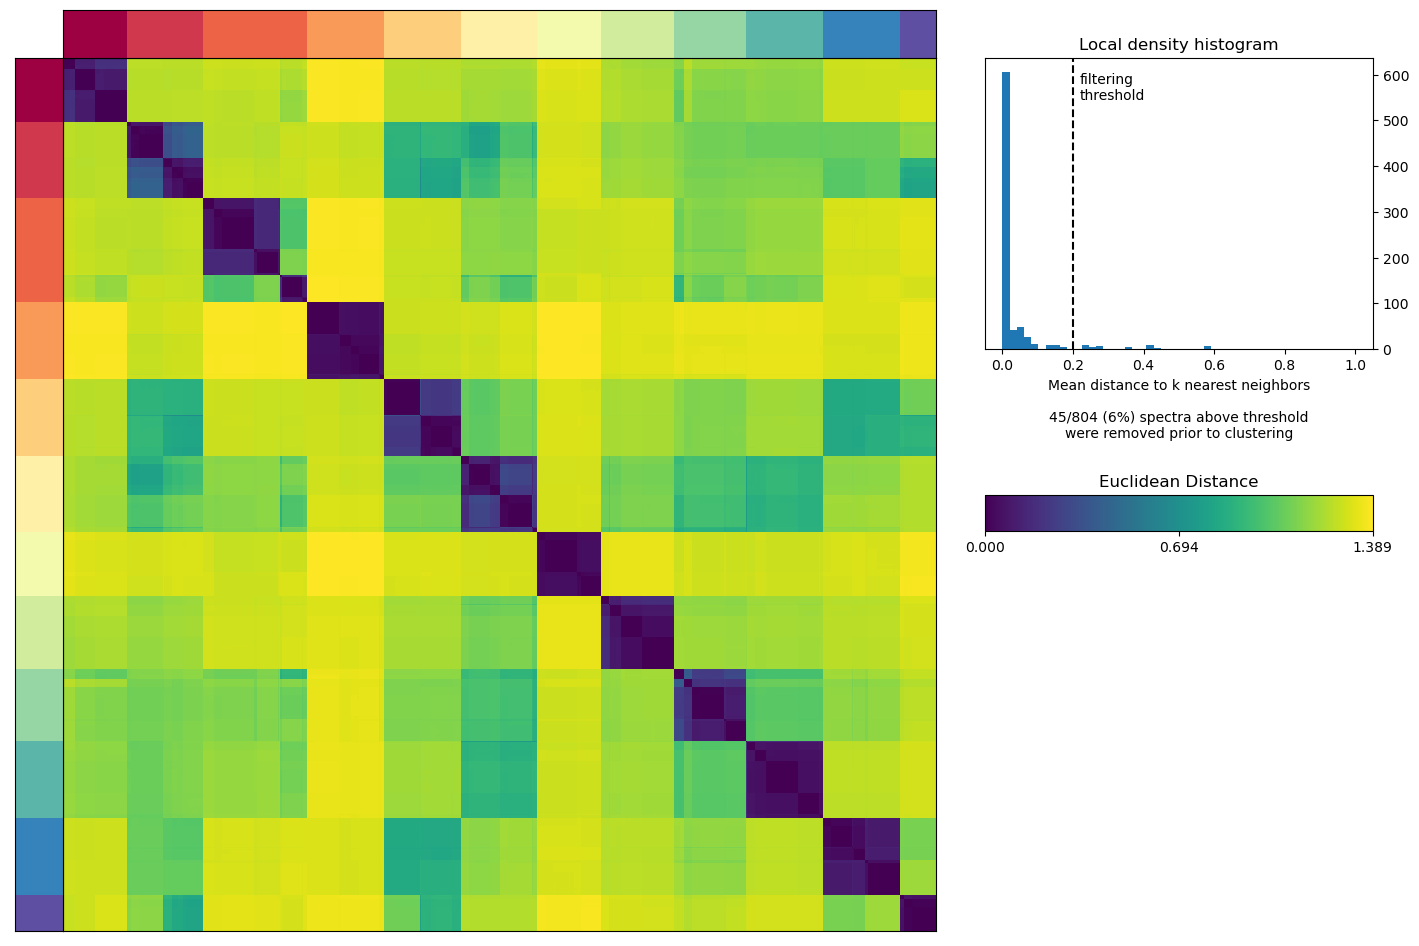

In [82]:
cnmf_obj_corrected.combine(skip_missing_files=True)
cnmf_obj_corrected.consensus(k=12, density_threshold=0.2, show_clustering=True, close_clustergram_fig=False)

In [83]:
(usage_bc, spectra_scores_bc, spectra_tpm_bc, top_genes_bc) = cnmf_obj_corrected.load_results(K=12, density_threshold=0.2)
usage_bc.head()

,1,2,3,4,5,6,7,8,9,10,11,12
CD4_1_Thymus_878524,0.105034,0.011767,0.077907,0.011828,0.000000,0.067606,0.000000,0.161615,0.008476,0.000000,0.001586,0.554179
CD4_1_Thymus_679405,0.032884,0.017256,0.014720,0.000000,0.000000,0.004368,0.016805,0.030144,0.000000,0.000000,0.004619,0.879204
CD4_1_Thymus_281188,0.000000,0.000000,0.091313,0.000000,0.097787,0.143018,0.000000,0.309982,0.073284,0.000000,0.000000,0.284615
CD4_1_Thymus_285601,0.466561,0.000000,0.069729,0.000000,0.243764,0.000000,0.149902,0.003355,0.060827,0.004819,0.000114,0.000928
CD4_1_Thymus_174537,0.000000,0.000000,0.113441,0.003682,0.000000,0.069125,0.000000,0.153417,0.011662,0.010356,0.003810,0.634506


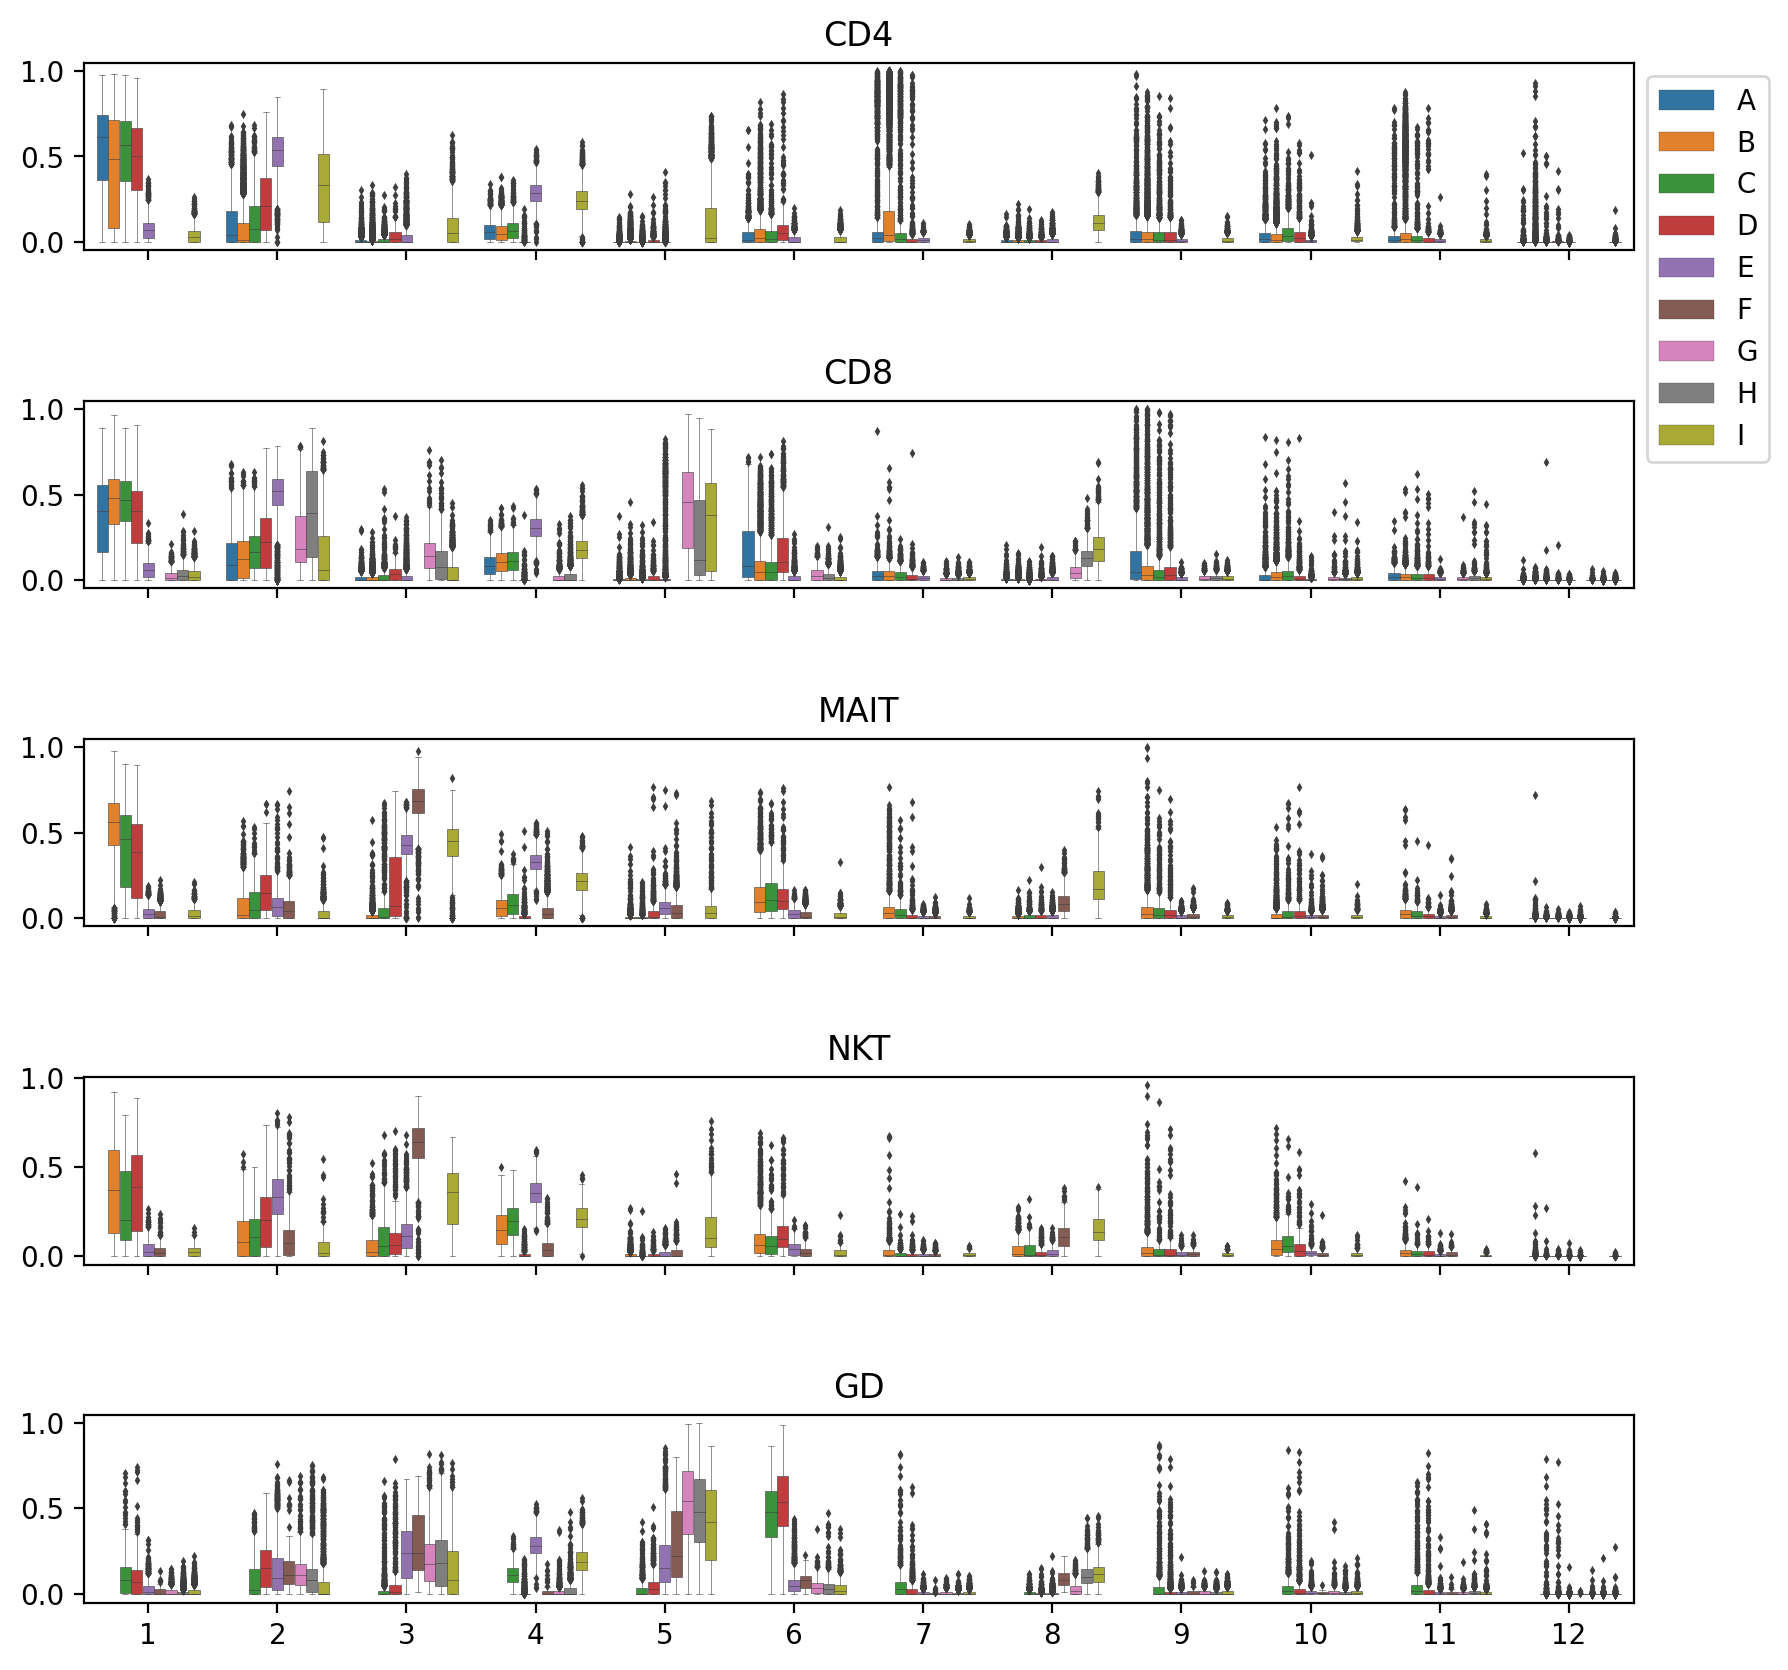

In [84]:
usage_norm_forplot = usage.unstack().reset_index()
usage_norm_forplot = pd.merge(left=usage_norm_forplot, right=adata.obs[['cell.ident', 'Batch']], left_on='level_1', right_index=True)
usage_norm_forplot.columns = ['GEP', 'cell', 'usage', 'cell.ident', 'batch']

cluster_order =["CD4", "CD8",  "MAIT", "NKT",  "GD"]
(fig,axes) = plt.subplots(len(cluster_order),1, figsize=(10,10), dpi=200, gridspec_kw={'hspace':.8})
for i,k in enumerate(cluster_order):
    g = usage_norm_forplot.loc[usage_norm_forplot['cell.ident'] == k, :]
    sns.boxplot(x='GEP', y='usage', hue='batch', ax=axes[i], data=g,
                fliersize=1,
                linewidth=0.2
               )
    axes[i].set_title(k)
    axes[i].legend(bbox_to_anchor=(1,1))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if i != (len(cluster_order)-1):
        axes[i].set_xticklabels([])
        
    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(bbox_to_anchor=(1,1))